In [1]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
import itertools
import matplotlib as mpl

warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2


rc = {'text.color': 'black',
      'axes.labelcolor': 'black',
      'xtick.color': 'black',
      'ytick.color': 'black',
      'axes.edgecolor': 'black',
      'font.family': 'Helvetica',
      'figure.dpi': 72 * 2,
      'savefig.dpi': 72 * 4
      }
mpl.rcParams.update(rc)

In [2]:
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
results_dir = os.path.join(output_dir, 'sfp_model', 'results_2D')
fig_dir = os.path.join(output_dir, 'figures')
lr = 0.0005
max_epoch = 30000
dset='nsdsyn'
roi_list = ['V1','V2','V3']
vsc='pRFsize'
nsd_subj_list = [utils.sub_number_to_string(sn, 'nsdsyn') for sn in np.arange(1,9)]
broderick_sn_list = [1, 6, 7, 45, 46, 62, 64, 81, 95, 114, 115, 121]
broderick_subj_list = [utils.sub_number_to_string(i, 'broderick') for i in broderick_sn_list]
ARGS_2D = ['sub','lr','eph','roi','dset']
roi_pal = [sns.color_palette('dark', 10)[:][k] for k in  [3,2,0]]
roi_pal.insert(0, (0.3,0.3,0.3))
stim_classes=['annulus', 'reverse spiral', 'pinwheel', 'forward spiral']

# Load model parameters

In [4]:
pt_file_list = []
dset='nsdsyn'
for subj, roi in itertools.product(nsd_subj_list, ['V1', 'V2', 'V3']):
    file_name = os.path.join(output_dir, 'sfp_model', 'results_2D', dset,
                             f'model-params_lr-{lr}_eph-{max_epoch}_dset-{dset}_sub-{subj}_roi-{roi}_vs-{vsc}.pt')
    pt_file_list.append(file_name)
final_params = model.load_all_models(pt_file_list, *ARGS_2D)


# Predict synthetic data based on the model parameters

In [6]:
stim_info='/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/nsdsyn_stim_description.csv'
stim_info = vis2D.get_w_a_and_w_r_for_each_stim_class(stim_info)

In [10]:
ecc_range = (0, 12)
n_ecc = 121
angle_range = (np.deg2rad(0), np.deg2rad(360))
n_angle = 360
ecc_col = 'eccentricity'
angle_col = 'angle'
synthetic_df = vis2D.make_synthetic_dataframe_for_2D(stim_info,
                                                ecc_range, n_ecc,
                                                angle_range, n_angle,
                                                ecc_col, angle_col)

In [12]:
synthetic_df['local_ori'] = prep.calculate_local_orientation(w_a = synthetic_df['w_a'],
                                                     w_r = synthetic_df['w_r'],
                                                     retinotopic_angle=synthetic_df[angle_col],
                                                     angle_in_radians=True,
                                                     reference_frame='relative')

In [29]:
synthetic_df['Pv'] = synthetic_df.apply(model.get_Pv_row, 
                                        params=final_params.query('sub == "subj01" & vroinames == "V1"'), 
                                        axis=1)


# Load synthetic data

## NSD

In [5]:
pt_file_list = []
ecc_1, ecc_2, n_ecc = 0, 12, 121
angle_1, angle_2, n_angle = 0, 360, 361
dset='nsdsyn'
for subj, roi, frame in itertools.product(nsd_subj_list, ['V1', 'V2', 'V3'], ['relative','absolute']):
    file_name = os.path.join(output_dir, 'sfp_model', 'prediction_2D', dset,
                             f'prediction_frame-{frame}_eccentricity-{ecc_1}-{ecc_2}-{n_ecc}_angle-{angle_1}-{angle_2}-{n_angle}_lr-0.0005_eph-30000_dset-{dset}_sub-{subj}_roi-{roi}_vs-pRFsize.h5')
    pt_file_list.append(file_name)
nsd_prediction = utils.load_dataframes(pt_file_list, *ARGS_2D+['frame'])

nsd_precision_s =  pd.read_csv(os.path.join(output_dir, 'dataframes', dset, 'precision', f'precision-s_dset-{dset}_vs-pRFsize.csv'))
nsd_df = pd.merge(nsd_prediction, nsd_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])

## Broderick et al

In [6]:
pt_file_list = []
ecc_1, ecc_2, n_ecc = 0, 12, 121
angle_1, angle_2, n_angle = 0, 360, 361
dset='broderick'
for subj, roi, frame in itertools.product(broderick_subj_list, ['V1'], ['relative','absolute']):
    file_name = os.path.join(output_dir, 'sfp_model', 'prediction_2D', dset,
                             f'tfunc-corrected_prediction_frame-{frame}_eccentricity-{ecc_1}-{ecc_2}-{n_ecc}_angle-{angle_1}-{angle_2}-{n_angle}_lr-0.0005_eph-30000_dset-{dset}_sub-{subj}_roi-{roi}_vs-pRFsize.h5')
    pt_file_list.append(file_name)
broderick_prediction = utils.load_dataframes(pt_file_list, *ARGS_2D)

broderick_precision_s =  pd.read_csv(os.path.join(output_dir, 'dataframes', dset, 'precision', f'precision-s_dset-{dset}_vs-pRFsize.csv'))
broderick_df = pd.merge(broderick_prediction, broderick_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])

In [7]:
broderick_df['dset_type'] = 'Broderick et al. V1'
nsd_df['dset_type'] = nsd_df['vroinames'].apply(lambda x: f'NSD {x}')
final_df = pd.concat((broderick_df, nsd_df), axis=0)

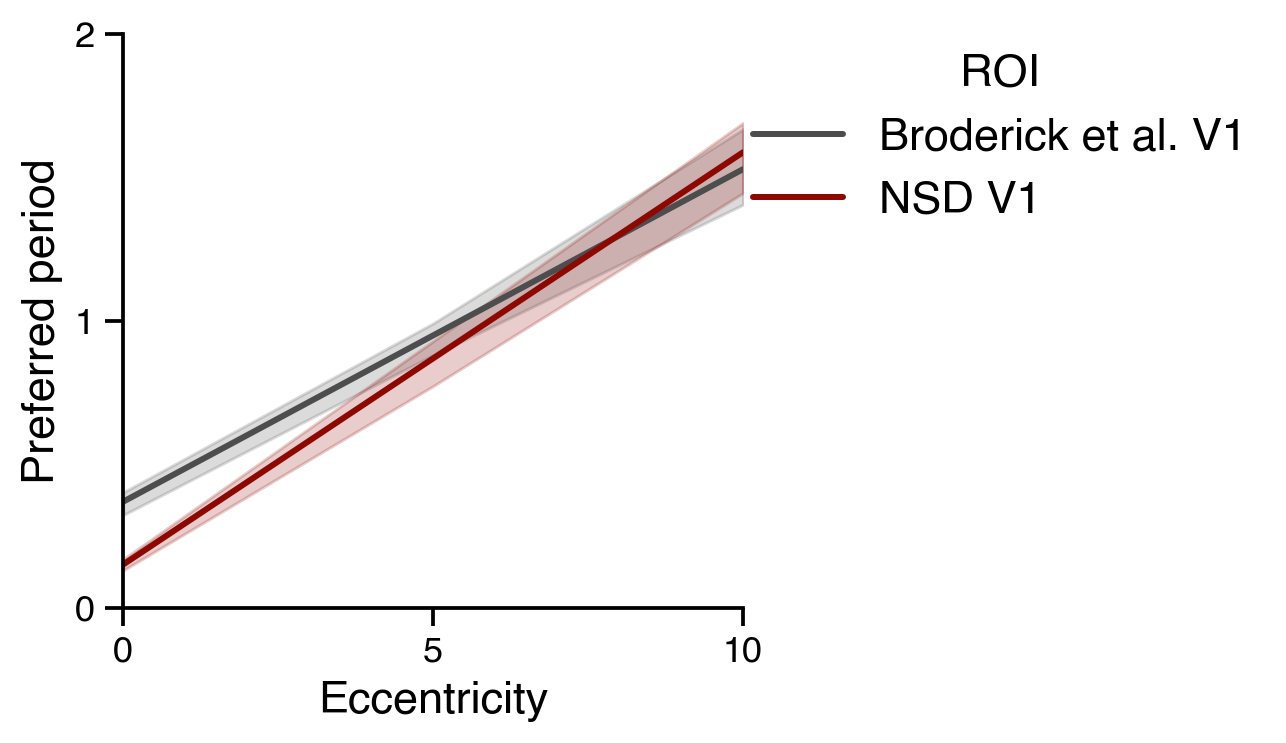

In [9]:
ecc_list = [0, 5, 10]
ecc_df = final_df.query('frame == "relative" & eccentricity in @ecc_list & vroinames == "V1"')
ecc_df = ecc_df.groupby(['sub','dset_type','eccentricity']).mean().reset_index()
vis2D.plot_preferred_period(ecc_df,
                            x='eccentricity', y='Pv', precision='precision',
                            hue='dset_type', hue_order=['Broderick et al. V1', 'NSD V1'],
                            col=None, palette=roi_pal,
                            lgd_title='ROI', width=3,
                            xlim=(0,10), ylim=(0,2), yticks=[0,1,2],
                            save_path=os.path.join('/Users/jh7685/Dropbox/NYU/Projects/SF/figs_tmp/pp_averaged_v1.svg'))

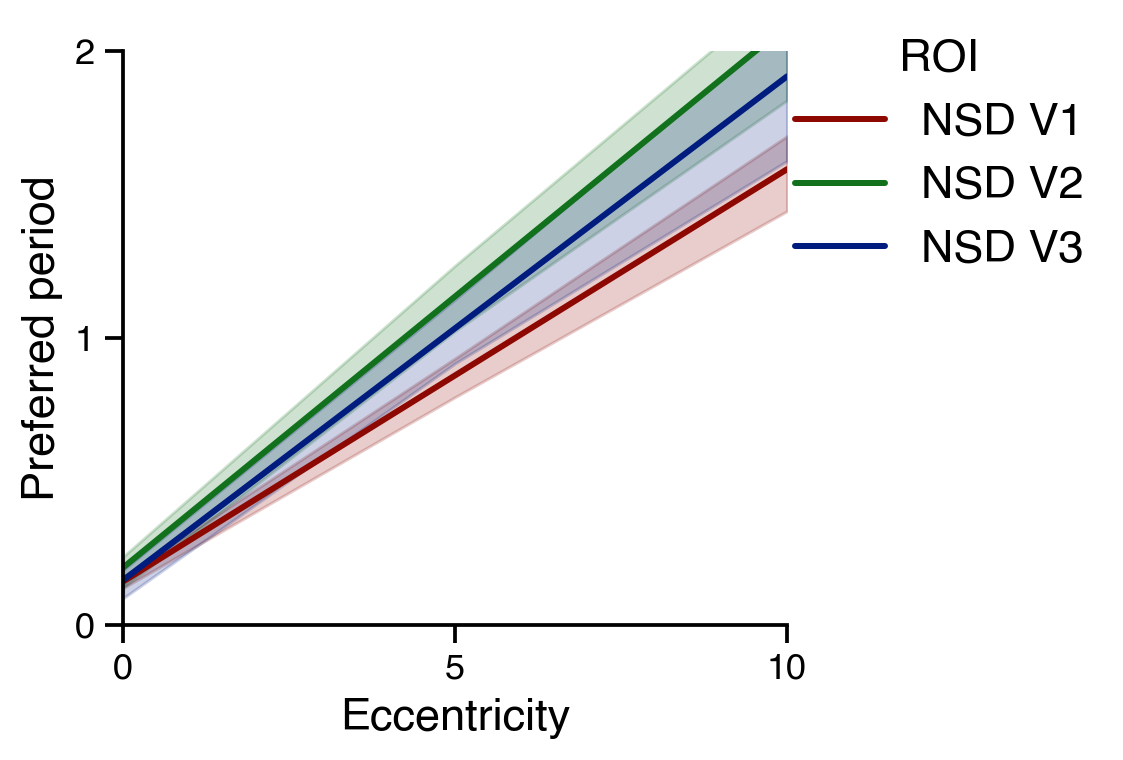

In [12]:
ecc_list = [0, 5, 10]
ecc_df = final_df.query('frame == "relative" & eccentricity in @ecc_list & dset == "nsdsyn"')
ecc_df = ecc_df.groupby(['sub','dset_type','eccentricity']).mean().reset_index()
vis2D.plot_preferred_period(ecc_df,
                            x='eccentricity', y='Pv', precision='precision',
                            hue='dset_type', hue_order=['NSD V1','NSD V2', 'NSD V3'],
                            col=None, palette=roi_pal[1:],
                            lgd_title='ROI', width=3,
                            xlim=(0,10), ylim=(0,2), yticks=[0,1,2],
                            save_path=os.path.join('/Users/jh7685/Dropbox/NYU/Projects/SF/figs_tmp/pp_averaged_nsdsyn1.svg'))

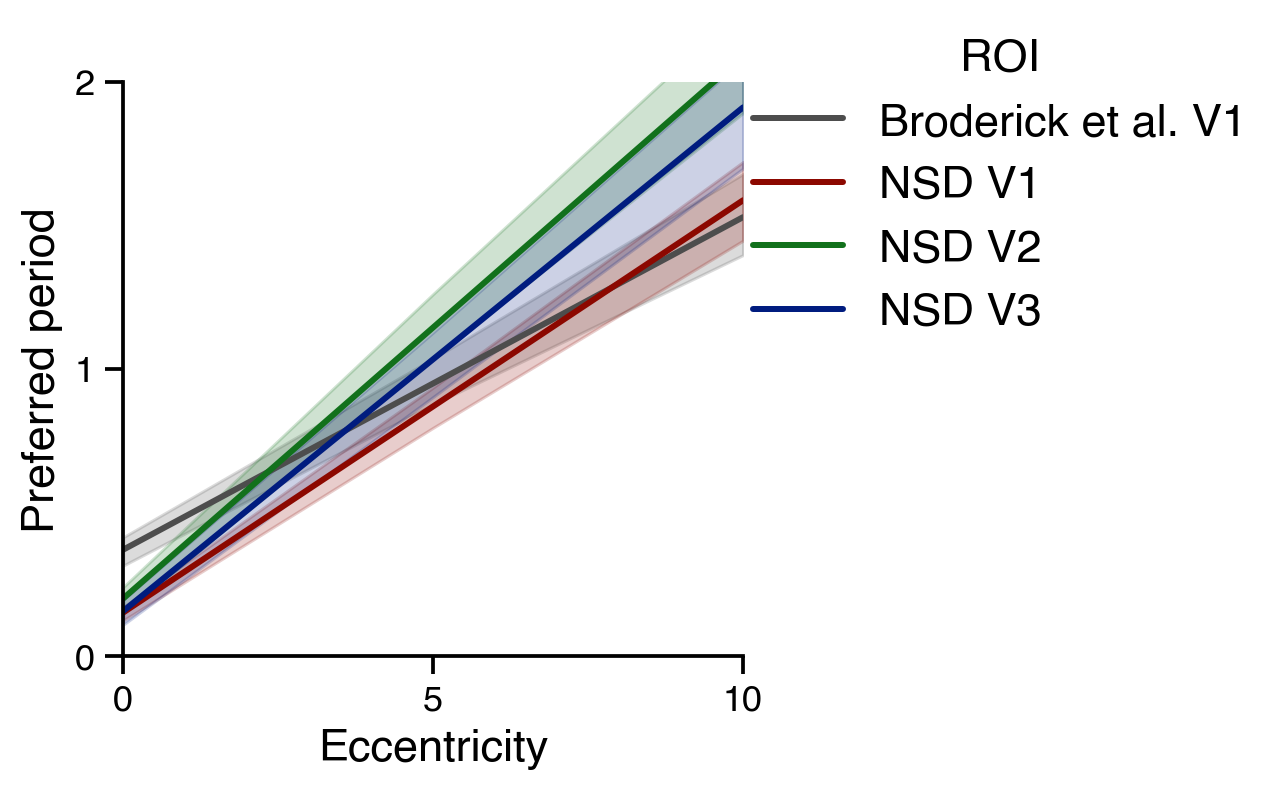

In [13]:
ecc_list = [0, 5, 10]
ecc_df = final_df.query('frame == "relative" & eccentricity in @ecc_list')
ecc_df = ecc_df.groupby(['sub','dset_type','eccentricity']).mean().reset_index()
vis2D.plot_preferred_period(ecc_df,
                            x='eccentricity', y='Pv', precision='precision',
                            hue='dset_type', hue_order=['Broderick et al. V1','NSD V1','NSD V2', 'NSD V3'],
                            col=None, palette=roi_pal,
                            lgd_title='ROI', width=3,
                            xlim=(0,10), ylim=(0,2), yticks=[0,1,2],
                            save_path=os.path.join('/Users/jh7685/Dropbox/NYU/Projects/SF/figs_tmp/pp_averaged_all.svg'))

# Plot preferred period for each parameter

## P1: Horizontal gratings vs. vertical gratings

In [20]:
ecc_df = final_df.query('frame == "absolute" & vroinames == "V1" & names in @grating_list')
ecc_df = ecc_df.groupby(['sub','dset_type','names', 'eccentricity']).mean().reset_index()
ecc_df['Pv'].max()

2.692802

In [31]:
ecc_df

,sub,dset_type,names,eccentricity,w_r,w_a,angle,local_ori,Pv,precision,value_and_weights
0,subj01,NSD V1,horizontal,0.0,0.0,6.0,3.141593,1.570796,0.208064,1.342082,0.208064+1.342082j
1,subj01,NSD V1,horizontal,5.0,0.0,6.0,3.141593,1.570796,0.875823,1.342082,0.875823+1.342082j
2,subj01,NSD V1,horizontal,10.0,0.0,6.0,3.141593,1.570796,1.543583,1.342082,1.543583+1.342082j
3,subj01,NSD V1,vertical,0.0,6.0,0.0,3.141593,0.000000,0.217389,1.342082,0.217389+1.342082j
4,subj01,NSD V1,vertical,5.0,6.0,0.0,3.141593,0.000000,0.915077,1.342082,0.915077+1.342082j
...,...,...,...,...,...,...,...,...,...,...,...
115,wlsubj121,Broderick et al. V1,horizontal,5.0,0.0,6.0,3.141593,1.570796,0.747546,5.596000,0.747546+5.596000j
116,wlsubj121,Broderick et al. V1,horizontal,10.0,0.0,6.0,3.141593,1.570796,0.685819,5.596000,0.685819+5.596000j
117,wlsubj121,Broderick et al. V1,vertical,0.0,6.0,0.0,3.141593,0.000000,1.018045,5.596000,1.018045+5.596000j
118,wlsubj121,Broderick et al. V1,vertical,5.0,6.0,0.0,3.141593,0.000000,0.940394,5.596000,0.940394+5.596000j


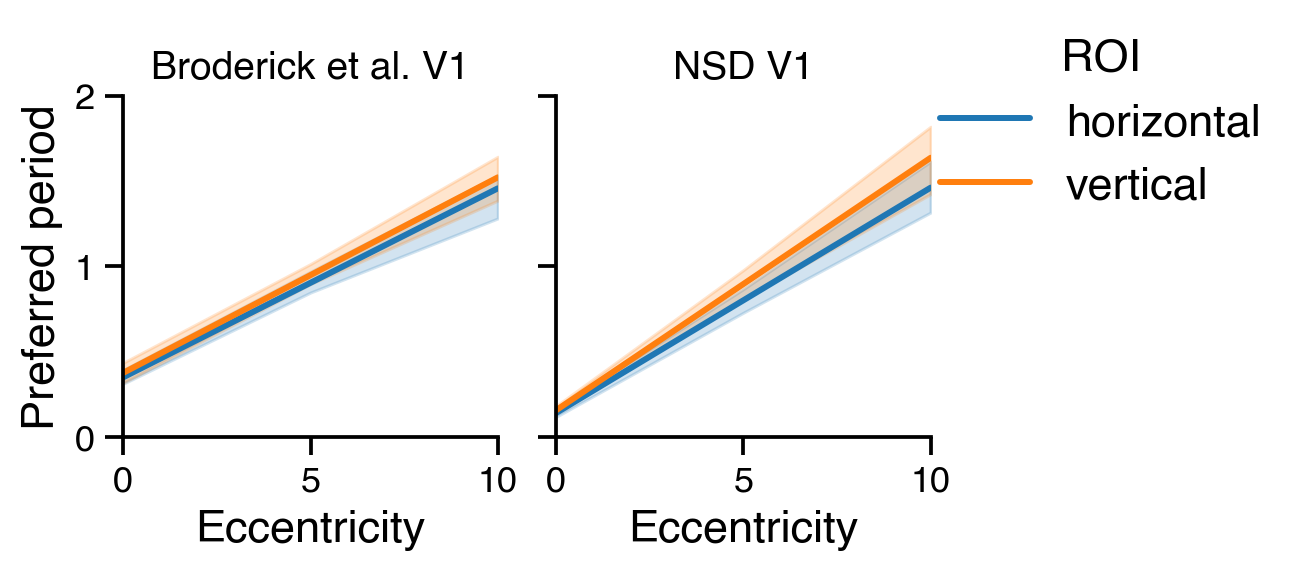

In [53]:
grating_list = ['horizontal', 'vertical']
p1_df = final_df.query('frame == "absolute" & vroinames == "V1" & eccentricity in @ecc_list & names in @grating_list')
p1_df = p1_df.groupby(['sub','dset_type','names', 'eccentricity']).mean().reset_index()
vis2D.plot_preferred_period(p1_df,
                            x='eccentricity', y='Pv', precision='precision',
                            hue='names', hue_order=['horizontal','vertical'],
                            col='dset_type', col_order=['Broderick et al. V1', 'NSD V1'], col_wrap=2, palette=['#1f77b4','#ff7f0e'],
                            lgd_title='ROI', width=3, aspect=0.9,
                            xlim=(0,10), yticks=[0,1,2],
                            save_path=os.path.join('/Users/jh7685/Dropbox/NYU/Projects/SF/pp_p1_v1.svg'))

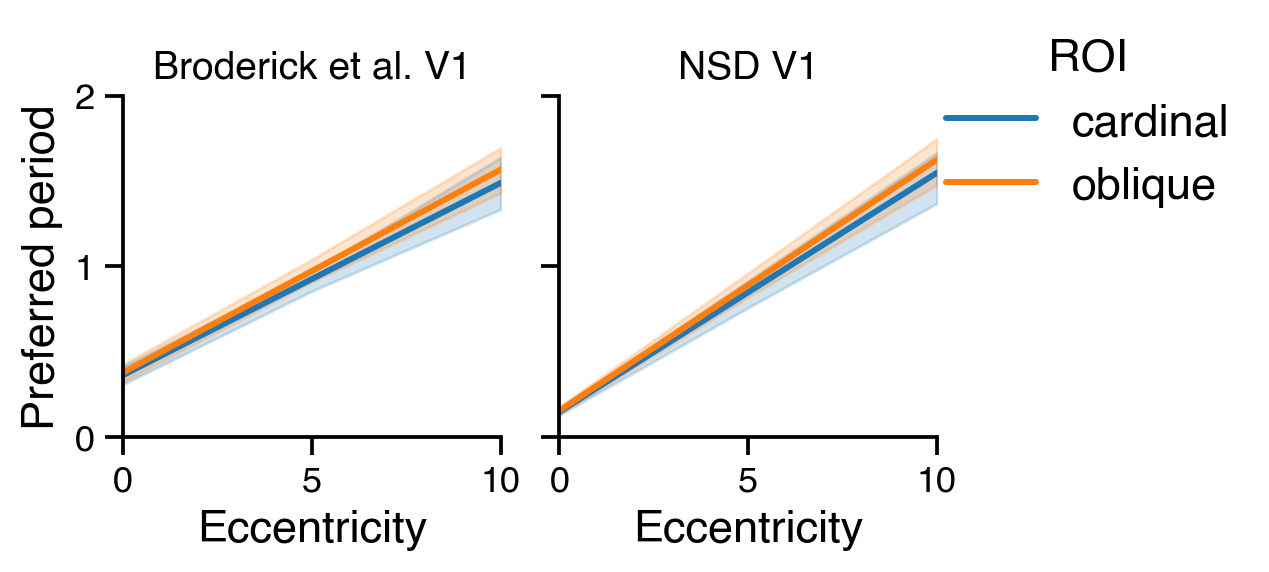

In [54]:
ecc_df = final_df.query('frame == "absolute" & vroinames == "V1" & eccentricity in @ecc_list')
ecc_df['p2_category'] = ecc_df.apply(lambda x: 'oblique' if 'oblique' in x['names'] else 'cardinal', axis=1)
ecc_df = ecc_df.groupby(['sub','dset_type','p2_category', 'eccentricity']).mean().reset_index()
vis2D.plot_preferred_period(ecc_df,
                            x='eccentricity', y='Pv', precision='precision',
                            hue='p2_category', hue_order=['cardinal','oblique'],
                            col='dset_type', col_order=['Broderick et al. V1', 'NSD V1'], col_wrap=2, palette=['#1f77b4','#ff7f0e'],
                            lgd_title='ROI', width=3, aspect=0.9,
                            xlim=(0,10), yticks=[0,1,2],
                            save_path=os.path.join('/Users/jh7685/Dropbox/NYU/Projects/SF/pp_p2_v1.png'))

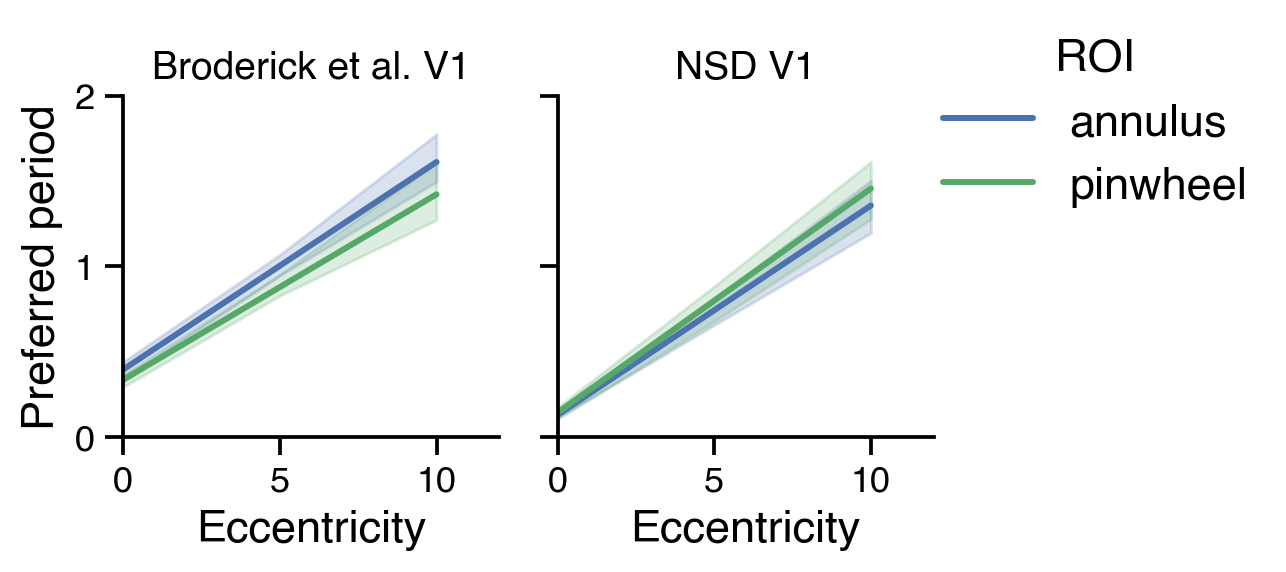

In [57]:
ecc_df = final_df.query('frame == "relative" & eccentricity in @ecc_list & vroinames == "V1"')
ecc_df = ecc_df.groupby(['sub','dset_type','names', 'eccentricity']).mean().reset_index()
vis2D.plot_preferred_period(ecc_df.query('names == "annulus" | names == "pinwheel"'),
                            x='eccentricity', y='Pv', precision='precision',
                            hue='names', hue_order=['annulus','pinwheel'],
                            col='dset_type', col_order=['Broderick et al. V1', 'NSD V1'], col_wrap=2, palette=utils.get_stim_colors(['annulus','pinwheel']),
                            lgd_title='ROI', width=3, aspect=0.9,
                            xlim=(0,12), yticks=[0,1,2],
                            save_path=os.path.join('/Users/jh7685/Dropbox/NYU/Projects/SF/pp_p3.svg'))

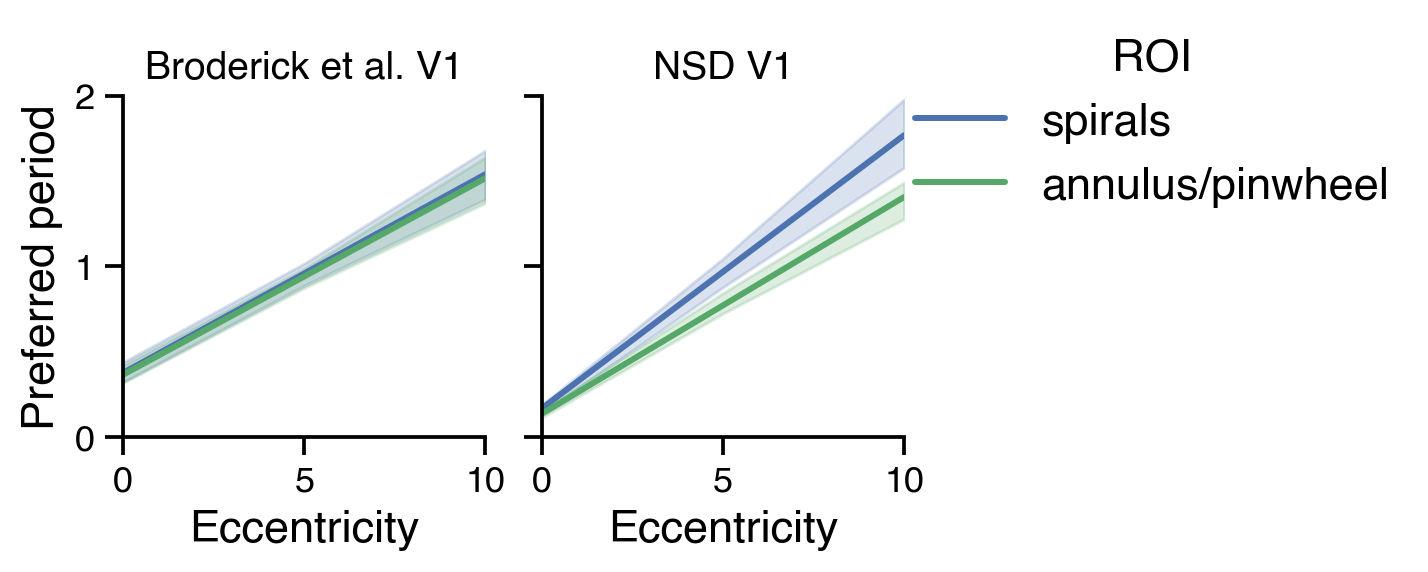

In [62]:
ecc_df = final_df.query('frame == "relative" & vroinames == "V1" & eccentricity in @ecc_list')
ecc_df['p4_category'] = ecc_df.apply(lambda x: 'spirals' if 'spiral' in x['names'] else 'annulus/pinwheel', axis=1)
ecc_df = ecc_df.groupby(['sub','dset_type','p4_category', 'eccentricity']).mean().reset_index()
vis2D.plot_preferred_period(ecc_df,
                            x='eccentricity', y='Pv', precision='precision',
                            hue='p4_category', hue_order=['spirals','annulus/pinwheel'],
                            col='dset_type', col_order=['Broderick et al. V1', 'NSD V1'], col_wrap=2, palette=utils.get_stim_colors(['annulus','pinwheel']),
                            lgd_title='ROI', width=3, aspect=0.9,
                            xlim=(0,10), yticks=[0,1,2],
                            save_path=os.path.join('/Users/jh7685/Dropbox/NYU/Projects/SF/pp_p4.svg'))

In [118]:
final_df.query('3 < eccentricity <3.1').eccentricity.unique()

array([3.08571429, 3.        ])

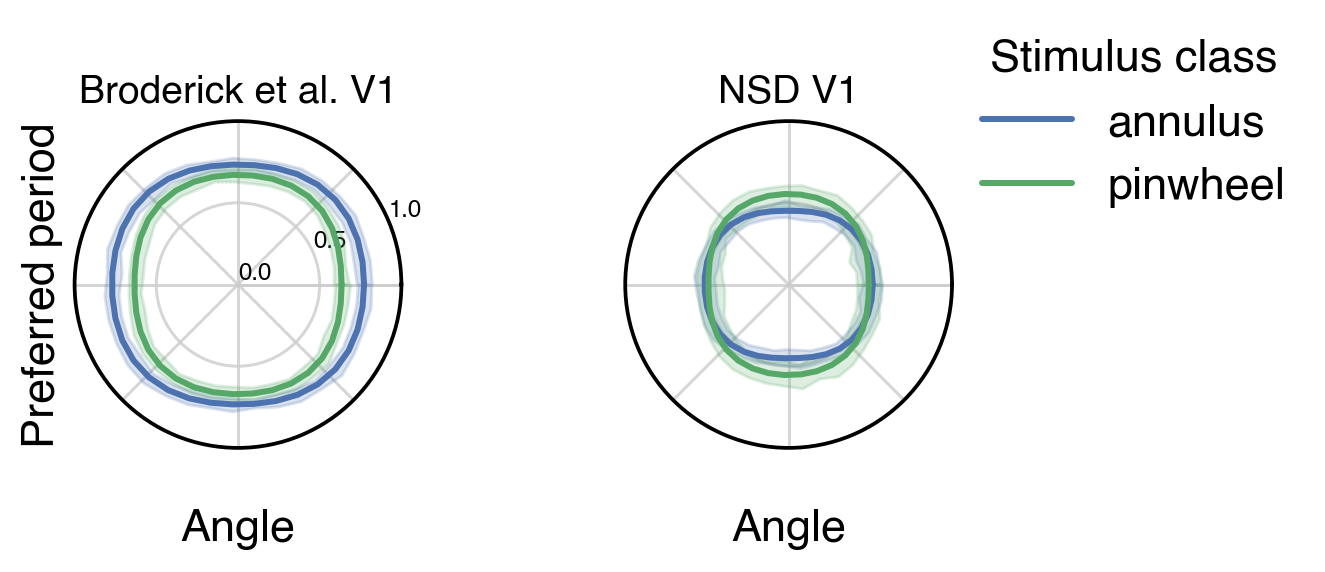

In [160]:
ecc_df = final_df.query('frame == "relative" & 2.99 < eccentricity < 3.1 & vroinames == "V1"')
ecc_df = ecc_df.groupby(['sub','dset_type','names', 'angle']).mean().reset_index()
vis2D.plot_preferred_period(ecc_df.query('names == "annulus" | names == "pinwheel"'),
                            x='angle', y='Pv', precision='precision',
                            hue='names', hue_order=['annulus','pinwheel'],
                            col='dset_type', col_order=['Broderick et al. V1', 'NSD V1'], col_wrap=2, palette=utils.get_stim_colors(['annulus','pinwheel']),
                            lgd_title='Stimulus class', width=2.5, aspect=1, ylim=(0,1), yticks=[0,0.5, 1],
                            xlim=(0,2*np.pi), projection='polar',
                            save_path=os.path.join('/Users/jh7685/Dropbox/NYU/Projects/SF/polar_pp_ap_all.pdf'))

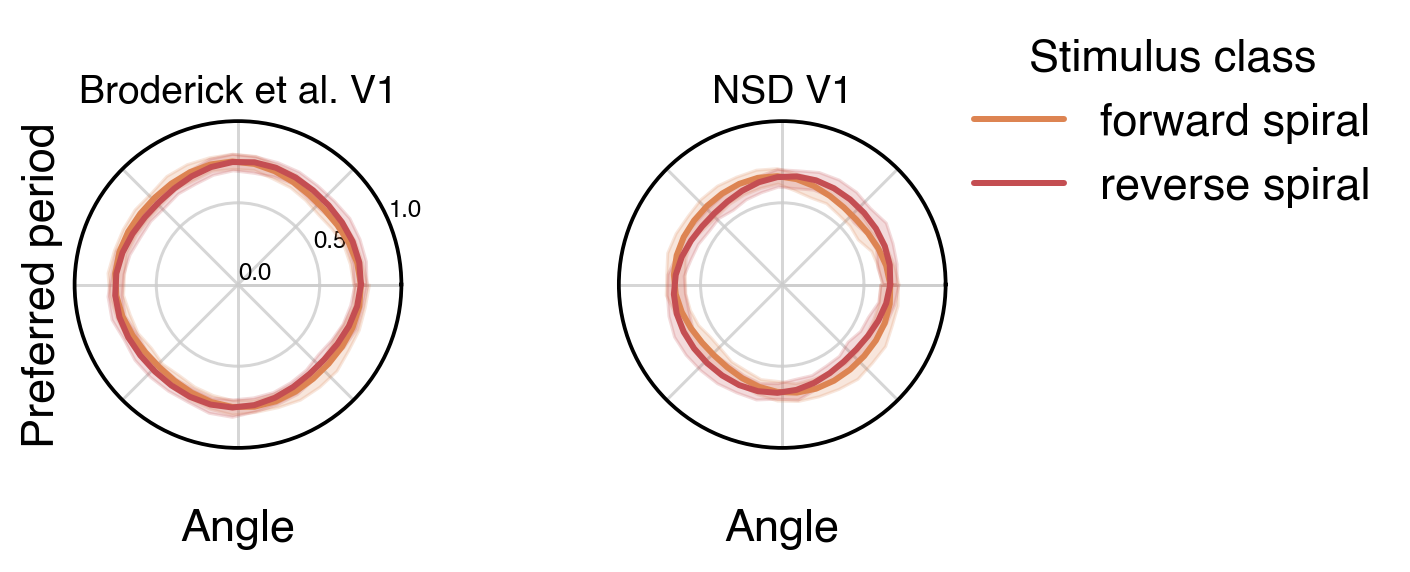

In [161]:
ecc_df = final_df.query('frame == "relative" & 2.99 < eccentricity < 3.1 & vroinames == "V1"')
ecc_df = ecc_df.groupby(['sub','dset_type','names', 'angle']).mean().reset_index()
vis2D.plot_preferred_period(ecc_df.query('names == "forward spiral" | names == "reverse spiral"'),
                            x='angle', y='Pv', precision='precision',
                            hue='names', hue_order=['forward spiral','reverse spiral'],
                            col='dset_type', col_order=['Broderick et al. V1', 'NSD V1'], col_wrap=2, palette=utils.get_stim_colors(['forward spiral','reverse spiral']),
                            lgd_title='Stimulus class', width=2.5, aspect=1, ylim=(0,1), yticks=[0,0.5, 1],
                            xlim=(0,2*np.pi), projection='polar',
                            save_path=os.path.join('/Users/jh7685/Dropbox/NYU/Projects/SF/polar_s_ap_all.pdf'))

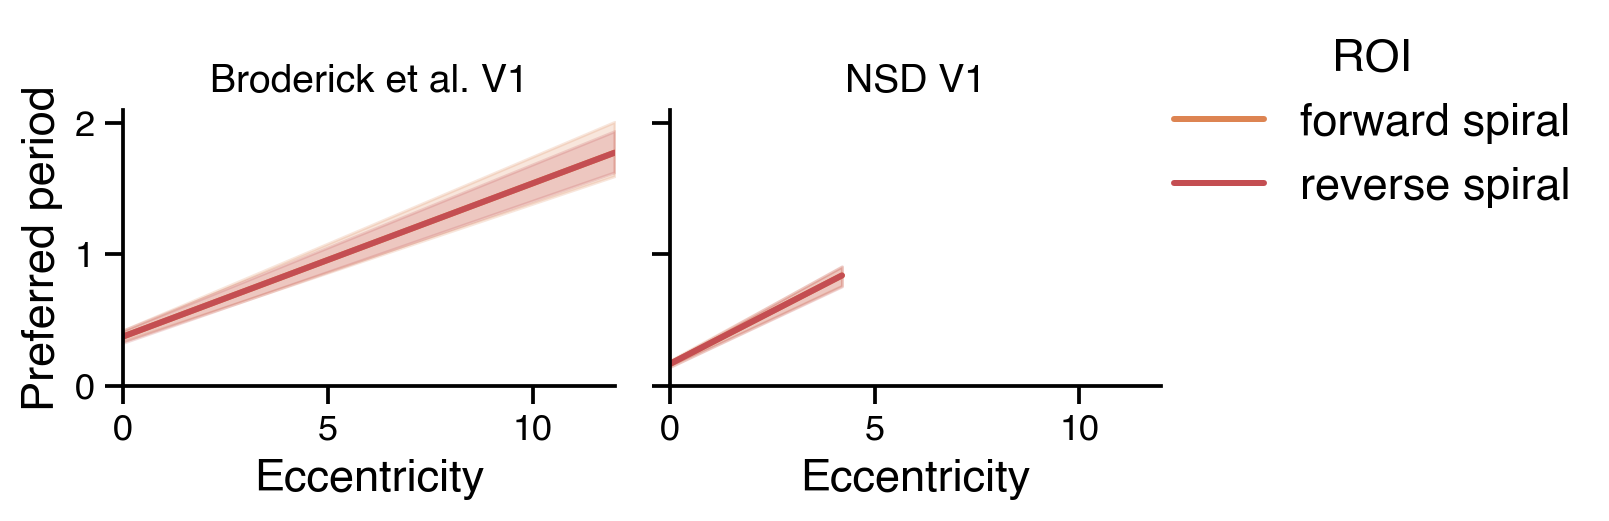

In [112]:
ecc_df = final_df.query('frame == "relative" & eccentricity in @ecc_list & vroinames == "V1"')
ecc_df = ecc_df.groupby(['sub', 'dset_type', 'names', 'eccentricity']).mean().reset_index()
vis2D.plot_preferred_period(ecc_df.query('names == "forward spiral" | names == "reverse spiral"'),
                            x = 'eccentricity', y = 'Pv', precision = 'precision',
                            hue = 'names', hue_order = ['forward spiral', 'reverse spiral'],
                            col = 'dset_type', col_order = ['Broderick et al. V1', 'NSD V1'], col_wrap = 2, palette = utils.get_stim_colors(
                                ['forward spiral', 'reverse spiral']),
                            lgd_title = 'ROI', width = 2,
                            xlim = (0, 12), yticks=[0,1,2],
save_path = os.path.join('/Users/jh7685/Dropbox/NYU/Projects/SF/pp_spiral_all.pdf'))

In [78]:
final_df.query('dset == "broderick"').eccentricity.unique()

array([ 0.        ,  0.34285714,  0.68571429,  1.02857143,  1.37142857,
        1.71428571,  2.05714286,  2.4       ,  2.74285714,  3.08571429,
        3.42857143,  3.77142857,  4.11428571,  4.45714286,  4.8       ,
        5.14285714,  5.48571429,  5.82857143,  6.17142857,  6.51428571,
        6.85714286,  7.2       ,  7.54285714,  7.88571429,  8.22857143,
        8.57142857,  8.91428571,  9.25714286,  9.6       ,  9.94285714,
       10.28571429, 10.62857143, 10.97142857, 11.31428571, 11.65714286,
       12.        ])

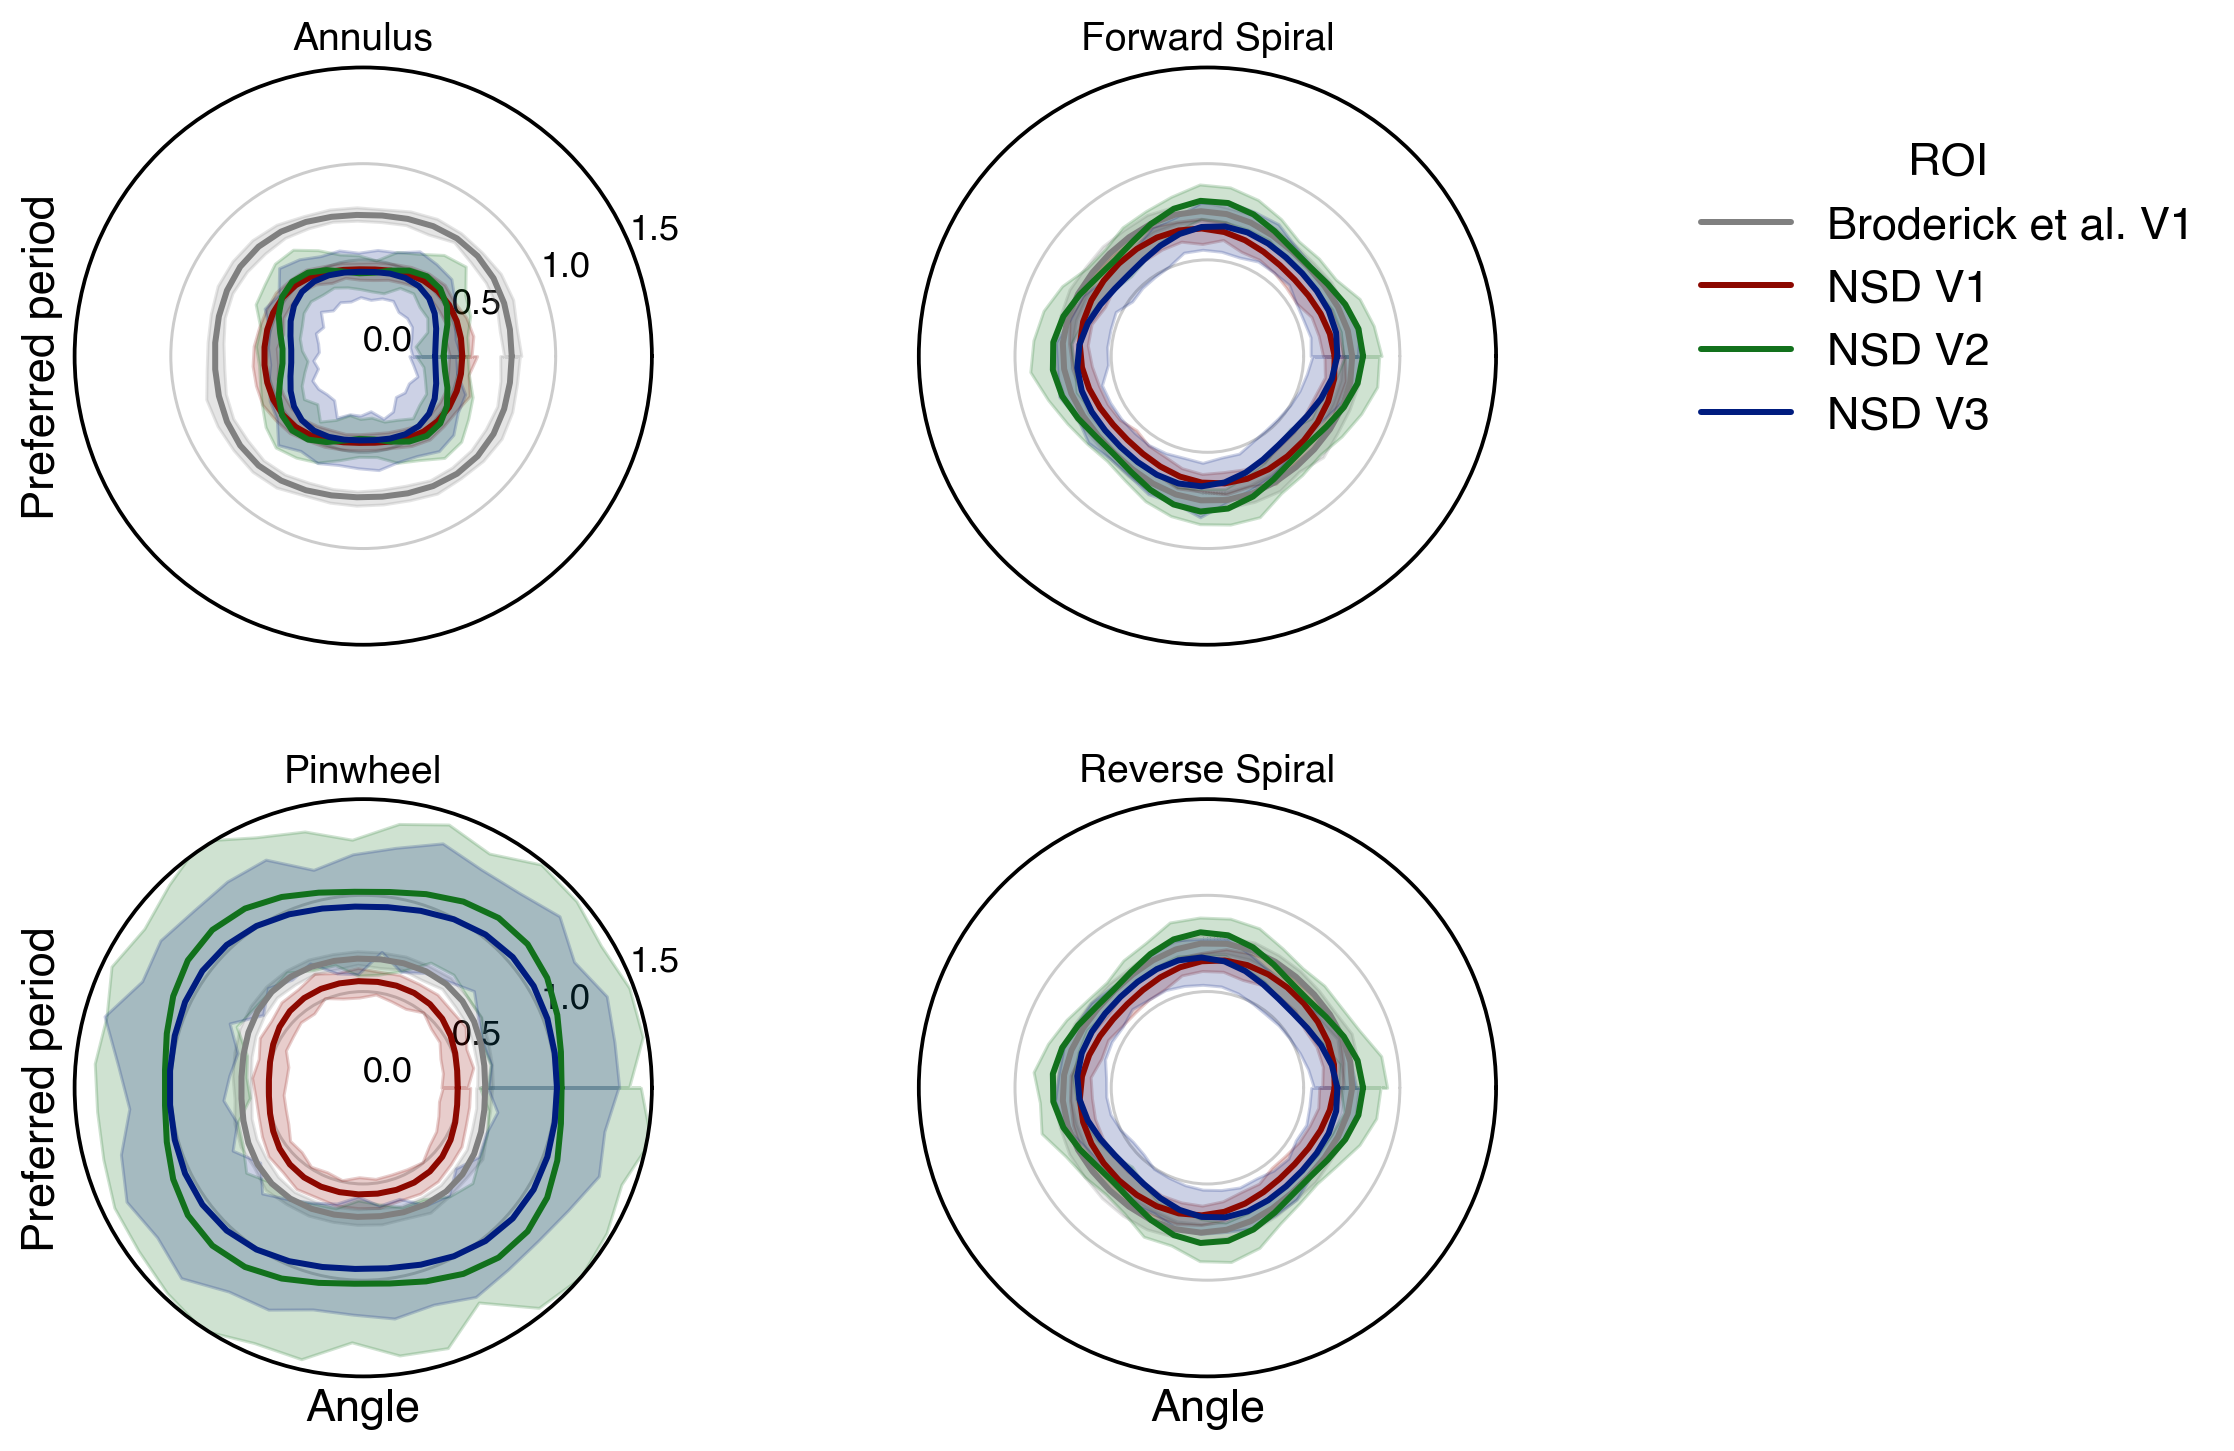

In [84]:
ecc_df = final_df.query('frame == "relative" & 2.99 < eccentricity < 3.1')
ecc_df = ecc_df.groupby(['sub','names', 'dset_type','angle']).mean().reset_index()
vis2D.plot_preferred_period(ecc_df,
                            x='angle', y='Pv', precision='precision',
                            hue='dset_type', hue_order=['Broderick et al. V1', 'NSD V1','NSD V2','NSD V3'],
                            col='names', col_wrap=2, palette=roi_pal,
                            lgd_title='ROI', width=3, projection='polar',
                            xlim=(0,2*np.pi), ylim=(0,1.5), yticks=[0,0.5, 1, 1.5],
                            save_path=os.path.join(' /Volumes/server/Projects/sfp_nsd/derivatives/figures/sfp_model/prediction_2D/all', 'angle_each_class.pdf'))

In [ ]:
    rc = {'axes.labelpad': 15,
          'axes.linewidth': 2,
          'axes.titlepad': 40,
          'axes.titleweight': "bold",
          'xtick.major.pad': 8,
          'ytick.major.pad': 8,
          'xtick.major.width': 2,
          'xtick.minor.width': 2,
          'ytick.major.width': 2,
          'xtick.major.size': 7,
          'ytick.major.size': 7,
          'grid.linewidth': 2,
          'font.family': 'Helvetica',
          'lines.linewidth': 2}

In [49]:
angle_df

,sub,vroinames,names,dset_type,angle,w_r,w_a,eccentricity,local_ori,Pv,precision,value_and_weights
0,subj01,V1,annulus,NSD V1,0.000000,6.0,0.0,2.1,0.000000,0.364249,1.342082,0.364249+1.342082j
1,subj01,V1,annulus,NSD V1,0.179520,6.0,0.0,2.1,0.179520,0.366276,1.342082,0.366276+1.342082j
2,subj01,V1,annulus,NSD V1,0.359039,6.0,0.0,2.1,0.359039,0.371093,1.342082,0.371093+1.342082j
3,subj01,V1,annulus,NSD V1,0.538559,6.0,0.0,2.1,0.538559,0.375559,1.342082,0.375559+1.342082j
4,subj01,V1,annulus,NSD V1,0.718078,6.0,0.0,2.1,0.718078,0.376310,1.342082,0.376310+1.342082j
...,...,...,...,...,...,...,...,...,...,...,...,...
5179,wlsubj121,V1,reverse spiral,Broderick et al. V1,5.565107,4.0,-4.0,6.0,1.638116,0.772221,5.596000,0.772221+5.596000j
5180,wlsubj121,V1,reverse spiral,Broderick et al. V1,5.744627,4.0,-4.0,6.0,1.817636,0.779940,5.596000,0.779940+5.596000j
5181,wlsubj121,V1,reverse spiral,Broderick et al. V1,5.924146,4.0,-4.0,6.0,1.997155,0.796487,5.596000,0.796487+5.596000j
5182,wlsubj121,V1,reverse spiral,Broderick et al. V1,6.103666,4.0,-4.0,6.0,2.176675,0.821393,5.596000,0.821393+5.596000j


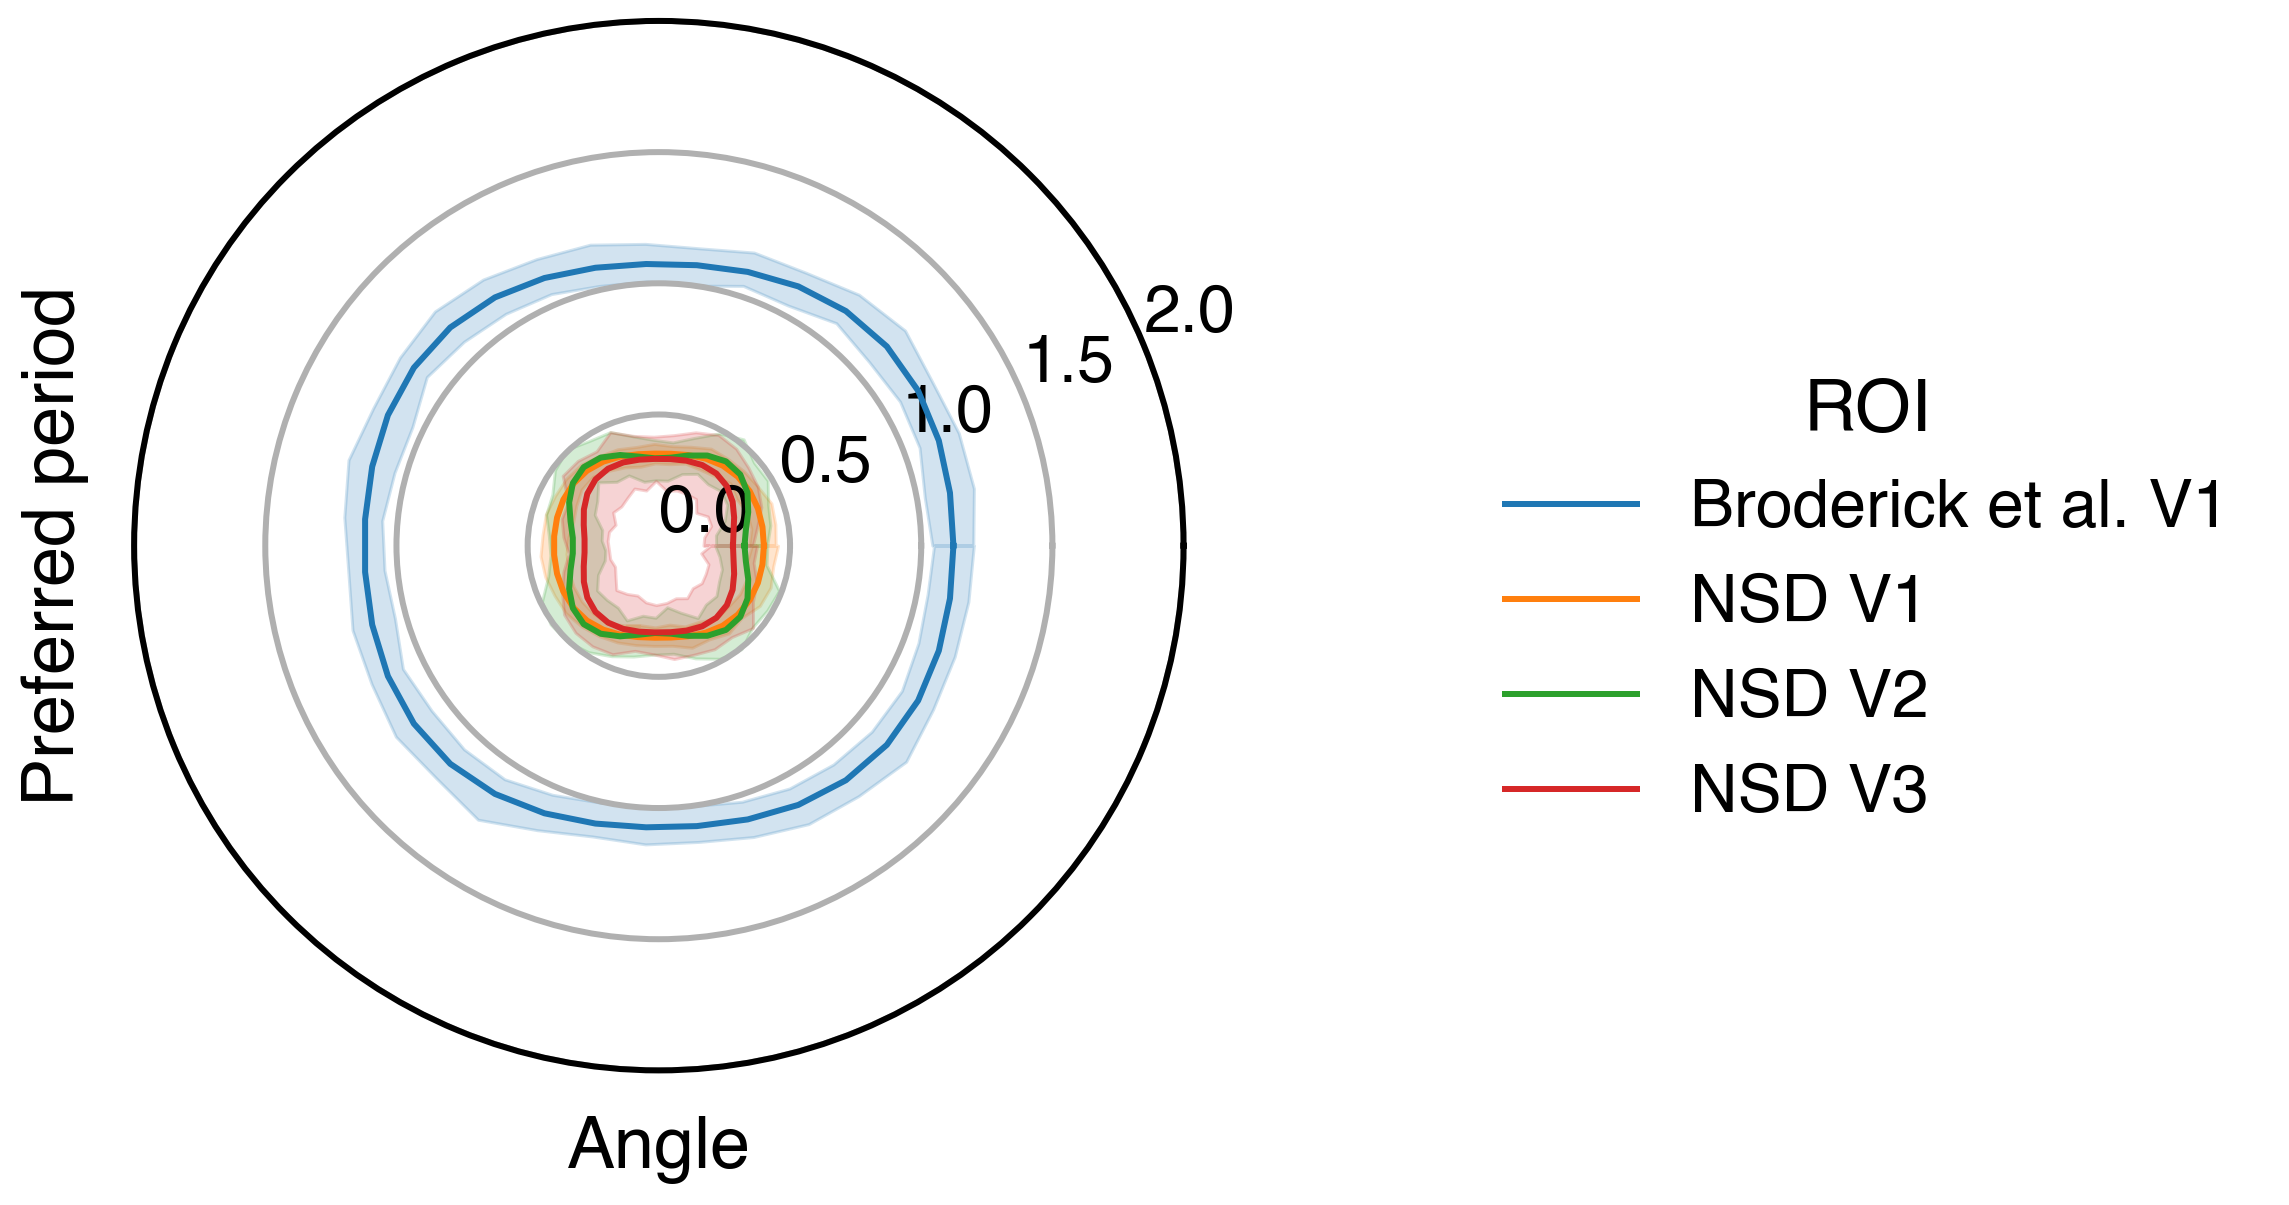

In [50]:
angle_df = final_df.query('frame == "relative" & names == "annulus"')
angle_df = angle_df.groupby(['sub','vroinames','names','dset_type','angle']).mean().reset_index()
vis2D.plot_preferred_period(angle_df, projection='polar',
                            x='angle', y='Pv', precision='precision',
                            hue='dset_type', hue_order=['Broderick et al. V1', 'NSD V1','NSD V2','NSD V3'],
                            col=None, xlim=(0, 2*np.pi),
                            lgd_title='ROI',
                            save_path=None)